<a href="https://colab.research.google.com/github/Ygor-m/Desafio_5/blob/main/C%C3%B3pia_de_Desafio_5_Ygor_Morais_G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas-profiling==3.3.0

In [ ]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder, OrdinalEncoder

In [ ]:
## Função para aplicar capping nos outliers
# Tentei o Z-score o Capping da forma tradicional, entretanto, verificando a documentação, chamando a função no início, tive melhores resultados. ("Apanhei bastante rs")
def cap_outliers(series, percentil):
    cap = series.quantile(percentil)
    series_capped = np.where(series > cap, cap, series)
    return series_capped

In [ ]:
from google.colab import files
upload = files.upload()

In [ ]:
# Carregando os dados
df = pd.read_csv('Data - data_desafio5 (2).csv')

# Gerando relatório de perfil dos dados para uma inspeção inicial detalhada
profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
profile.to_file("data_profile.html")  # Salvar o relatório como HTML

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
## Analisando as informações do Dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,264052.000000,264052.000000,188487.000000
mean,9.278778,5.031974,15288.833007
std,213.089442,115.484220,1730.391876
min,-74215.000000,0.000000,12346.000000
25%,1.000000,1.250000,13851.000000
50%,3.000000,2.100000,15159.000000
75%,10.000000,4.150000,16842.000000
max,74215.000000,38970.000000,18287.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264052 entries, 0 to 264051
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    264052 non-null  object 
 1   StockCode    264052 non-null  object 
 2   Description  263093 non-null  object 
 3   Quantity     264052 non-null  int64  
 4   InvoiceDate  264052 non-null  object 
 5   UnitPrice    264052 non-null  float64
 6   CustomerID   188487 non-null  float64
 7   Country      264052 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 16.1+ MB


In [ ]:
# Identificando valores nulos
df_missing = (
  df.isna().sum()
  .to_frame('missing_count')
  .join((df.isna().sum() / df.shape[0]).to_frame('missing_pct'))
  .sort_values('missing_count', ascending=False)
)

df_missing.style.format('{:.2%}', subset=['missing_pct'])

,missing_count,missing_pct
CustomerID,75565,28.62%
Description,959,0.36%
InvoiceNo,0,0.00%
StockCode,0,0.00%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
Country,0,0.00%


In [ ]:
# Removendo linhas onde CustomerID é nulo e tratando preços e quantidades negativas ou zero
df.dropna(subset=['CustomerID'], inplace=True)
df = df[(df['UnitPrice'] > 0) & (df['Quantity'] > 0)]

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,183926.000000,183926.000000,183926.000000
mean,13.308488,3.255730,15296.090107
std,178.920378,23.271492,1730.096542
min,1.000000,0.040000,12346.000000
25%,2.000000,1.250000,13869.000000
50%,6.000000,1.950000,15174.000000
75%,12.000000,3.750000,16850.000000
max,74215.000000,8142.750000,18287.000000


In [ ]:
## Removendo linhas duplicadas
df = df.copy()
df.drop_duplicates(inplace=True)

In [ ]:
## Função para identificação dos Outliers
def is_outlier(array, extreme=False):
  """Custom function to identify outliers in an array"""
  q1,q3 = np.quantile(array, [.25,.75])
  iqr = q3-q1

  factor = 3. if extreme else 1.5
  upper_outlier = q3 + factor*iqr
  lower_outlier = q1 - factor*iqr

  return (array < lower_outlier) | (array > upper_outlier)

In [ ]:
# Corrigindo tipos de dados
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

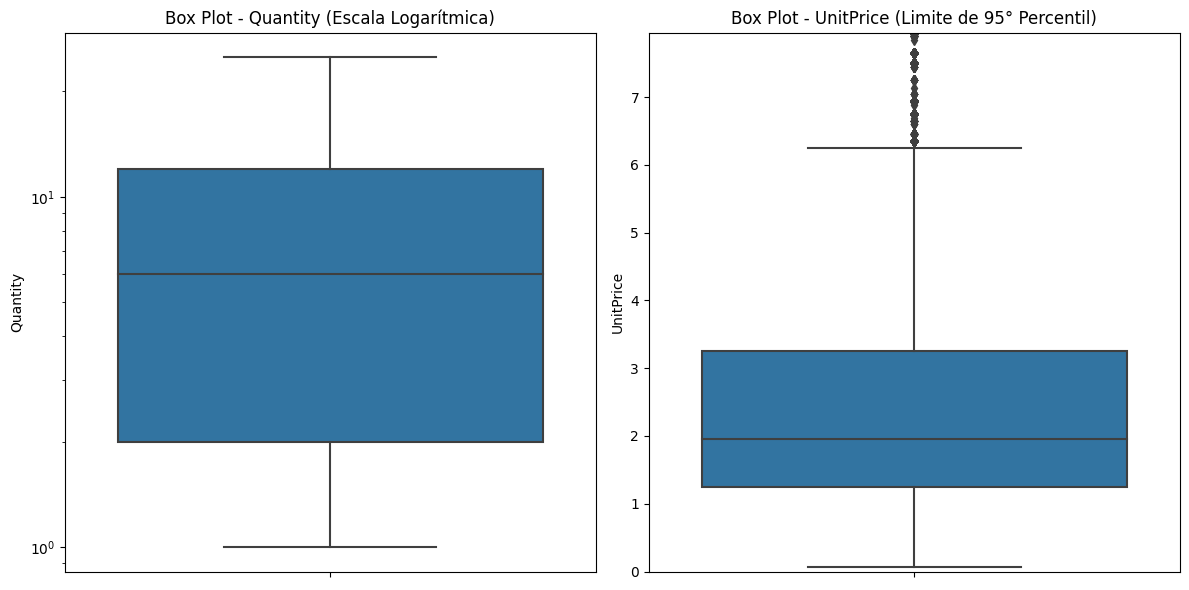

In [ ]:
# Análise dos dados com Box Plot para "Quantity" e "UnityPrice" (Tive que usar escala logarítmica para organizar o tamanho do gráfico)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['Quantity'])
plt.yscale('log')
plt.title('Box Plot - Quantity (Escala Logarítmica)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['UnitPrice'])
plt.ylim(0, df['UnitPrice'].quantile(0.95))
plt.title('Box Plot - UnitPrice (Limite de 95° Percentil)')

plt.tight_layout()
plt.show()

In [ ]:
## Tratamento de Outliers com Cap values
df['Quantity'] = cap_outliers(df['Quantity'], 0.99)
df['UnitPrice'] = cap_outliers(df['UnitPrice'], 0.99)

In [ ]:
## Criando uma coluna de preço total para cada compra
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

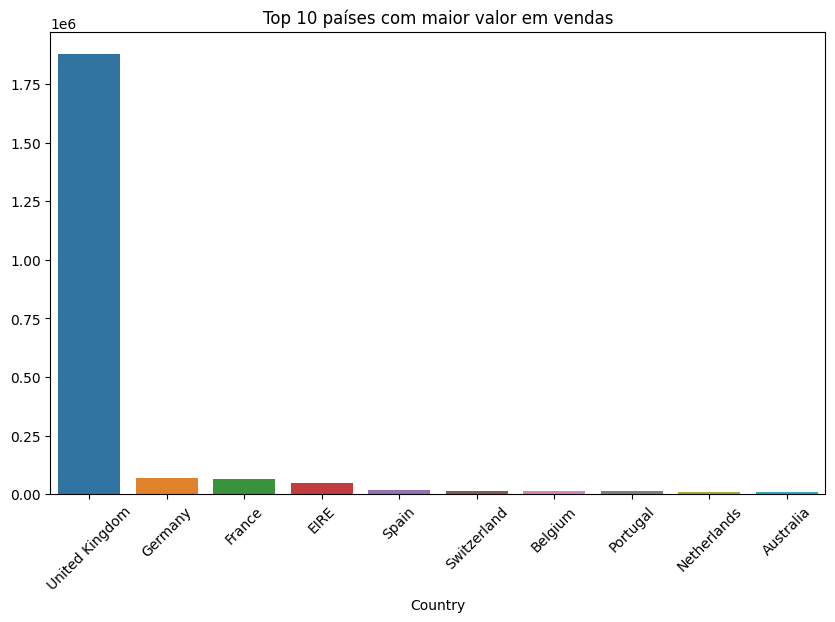

In [ ]:
## Top 10 países com maior valor em vendas
top_countries = df.groupby('Country')['TotalPrice'].sum().nlargest(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title('Top 10 países com maior valor em vendas')
plt.xticks(rotation=45)
plt.show()

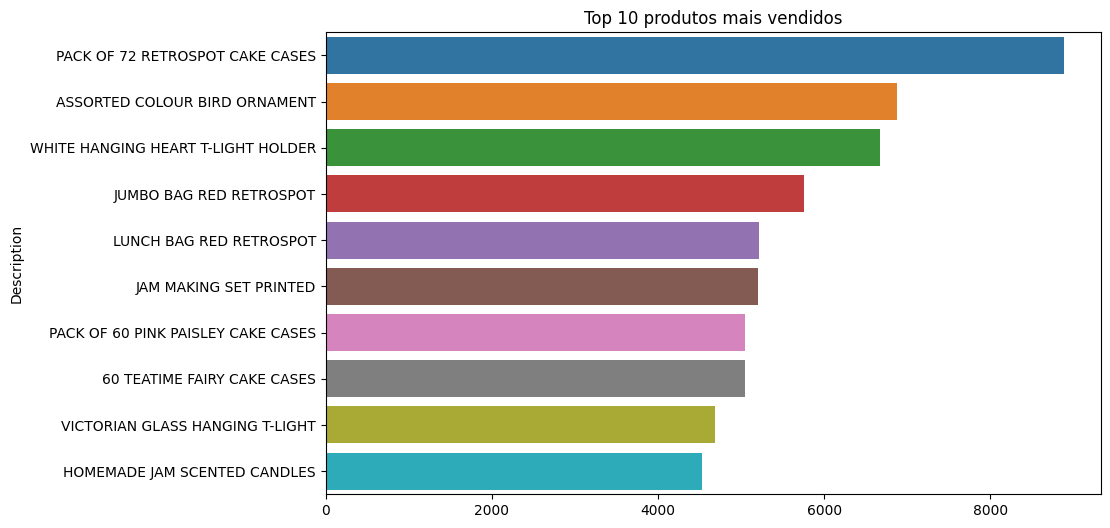

In [ ]:
## Top 10 produtos mais vendidos
top_products = df.groupby('Description')['Quantity'].sum().nlargest(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 produtos mais vendidos')
plt.show()


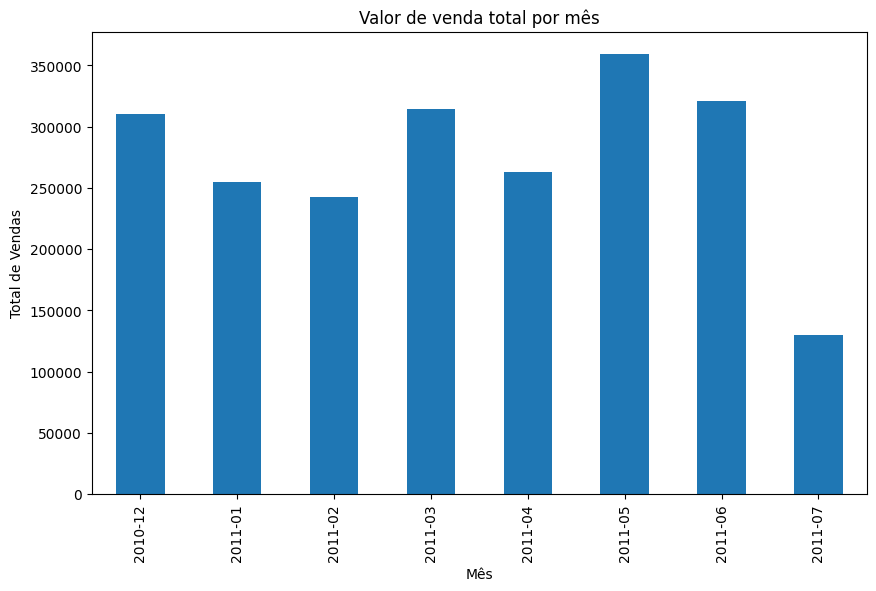

In [ ]:
## Valor de venda total por mês
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalPrice'].sum()
plt.figure(figsize=(10,6))
monthly_sales.plot(kind='bar')
plt.title('Valor de venda total por mês')
plt.xlabel('Mês')
plt.ylabel('Total de Vendas')
plt.show()

In [ ]:
## Última data de compra para calcular a recência
latest_date = df['InvoiceDate'].max()


In [ ]:
## Calculo de RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'mean'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

In [ ]:
## Mostrando os primeiros registros de RFM para verificar
print(rfm.head())

            Recency  Frequency   Monetary
CustomerID                               
12347            35         94  18.775000
12348           100          6  15.033333
12350           161         16  18.400000
12352           113         31  18.497097
12353            55          2  14.650000


In [ ]:
#Exportando o resultado para um aquivo .csv
rfm.to_csv('/output.csv', encoding='utf-8', index=False)